# Addressing Overfitting and Underfitting in Machine Learning Models

### 1. Import Libraries and Load Data

#### 1.1 Import Libaries

In [1]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import optuna

#### 1.2 Load CIFAR-100 dataset

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


#### 1.3 dataset simple EDA

In [4]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(np.unique(y_train))
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(np.unique(y_test))

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


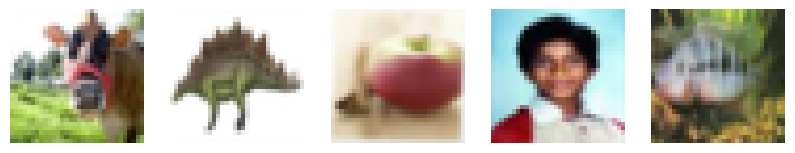

In [5]:
# Show sample images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(x_train[i])
    axes[i].axis("off")
plt.show()

#### 1.4 Normalize pixel values

In [6]:
x_train = x_train / 255.0
x_test = x_test / 255.0

#### 1.5 Split training data into training and validation sets

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

#### 1.6 Data augmentation


In [8]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomCrop(32, 32)
])

### 2 Building model:

#### 2.1 Define CNN model:

In [15]:
def create_model(dropout_rate=0.5, l2_reg=0.01, filters=32):
    inputs = keras.Input(shape=(32, 32, 3))  # Define input shape explicitly
    x = data_augmentation(inputs)  # Apply data augmentation

    x = layers.Conv2D(filters, (3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(filters * 2, (3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters * 2, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(filters * 4, (3,3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters * 4, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(100, activation='softmax')(x)

    model = keras.Model(inputs, outputs)  # Create a Model instance
    return model


#### 2.2 Hyperparameter tuning with Optuna:

In [16]:
def objective(trial):
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.6)
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-2, log=True)
    filters = trial.suggest_categorical("filters", [16, 32, 64])

    model = create_model(dropout_rate, l2_reg, filters)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val), verbose=0)

    val_acc = max(history.history['val_accuracy'])
    return val_acc

In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-02-09 18:04:26,199] A new study created in memory with name: no-name-29ac34fa-37e2-4af7-8ce4-182b99610a1e
[I 2025-02-09 18:06:21,432] Trial 0 finished with value: 0.3165000081062317 and parameters: {'dropout_rate': 0.47122814204405256, 'l2_reg': 0.0008096758073291904, 'filters': 32}. Best is trial 0 with value: 0.3165000081062317.
[I 2025-02-09 18:07:57,900] Trial 1 finished with value: 0.2840999960899353 and parameters: {'dropout_rate': 0.5722324717570196, 'l2_reg': 0.0004018236977235795, 'filters': 32}. Best is trial 0 with value: 0.3165000081062317.
[I 2025-02-09 18:09:31,050] Trial 2 finished with value: 0.3596999943256378 and parameters: {'dropout_rate': 0.3375837760523897, 'l2_reg': 6.446398937531312e-05, 'filters': 32}. Best is trial 2 with value: 0.3596999943256378.
[I 2025-02-09 18:11:02,020] Trial 3 finished with value: 0.25189998745918274 and parameters: {'dropout_rate': 0.5508651635096604, 'l2_reg': 0.004438731851734432, 'filters': 32}. Best is trial 2 with value: 0

In [18]:
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'dropout_rate': 0.3375837760523897, 'l2_reg': 6.446398937531312e-05, 'filters': 32}


### 3. Train final model with best hyperparameters:

In [23]:
final_model = create_model(**best_params)
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = final_model.fit(x_train, y_train, epochs=50, batch_size=128,
                          validation_data=(x_val, y_val), callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.0222 - loss: 4.5032 - val_accuracy: 0.0876 - val_loss: 3.9648
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.0945 - loss: 3.9081 - val_accuracy: 0.1676 - val_loss: 3.5117
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.1481 - loss: 3.5913 - val_accuracy: 0.2124 - val_loss: 3.2484
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.1916 - loss: 3.3828 - val_accuracy: 0.2464 - val_loss: 3.0823
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.2147 - loss: 3.2412 - val_accuracy: 0.2754 - val_loss: 2.9710
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.2429 - loss: 3.1120 - val_accuracy: 0.3040 - val_loss: 2.8135
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.2617 - loss: 3.0222 - val_accuracy: 0.3082 - val_loss: 2.7841
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.2793 - loss: 2.9474 - val_ac

### 4. Evalute final model:

In [24]:
test_loss, test_acc = final_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4516 - loss: 2.2163
Test accuracy: 0.4497


In [25]:
test_f1 = f1_score(y_test, np.argmax(final_model.predict(x_test), axis=-1), average='weighted')
print(f"Test F1 score: {test_f1:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test F1 score: 0.4408


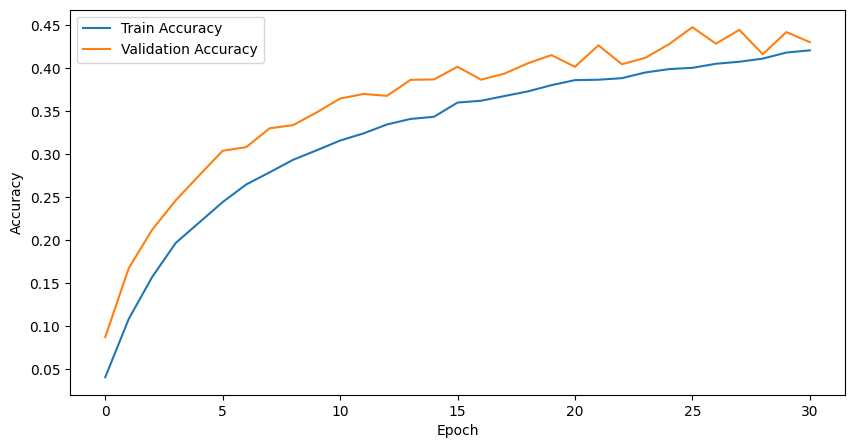

In [26]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()